# NLP[1] -- 构建词向量模型 -- Word2Vec与词嵌入

## 通过词向量构建语料库的表示  
计算机要处理自然语言就必须先把文本`encoding`成计算机能处理的表示形式, 常用的方式是词向量模型.  
本文使用的的语料库来自狗狗本地近期(2020年1月)的QQ群消息记录(共71509条消息). 在[上一节](https://github.com/HookeLiu/MutBot/blob/master/PyDeamon/%E5%BC%80%E5%8F%91%E7%AC%94%E8%AE%B0/sqlread_ppc.ipynb)使用pandas读取sqlite数据库并使用jieba分词和标注, 预处理结果存储到了`CQevePPC.db`中(出于尊重他人隐私, 不提供这个数据库).

### 相关知识介绍
人类运用语言文字是依赖大量背景知识和人类特有的脑结构的, 而目前计算机不可能直接处理, 对于程序而言任何一个文字或者单词都仅仅只是一个"token"(所以word2vec不仅仅可以用来处理任何语种的自然语言, 实际上它能处理任何有关联的"标签", 以后有机会再讲), 这大概就类似一个没了解过德语也没了解过汇编的人类看到`Wie geht es`与`cmp al, 0dh`一样吧...  
一般来说让计算机处理`向量`是比较适合的, 后端的各种形式的处理, 比如神经网络的输入, 通常也都是采用向量. 当然, 也可以人工建`分类词典`, 比如[Wordnet](https://baike.baidu.com/item/Wordnet/10349844?fr=aladdin)  .
所以, NLP的第一步也就是构建词汇的向量化表示模型. 把词汇向量化表示的方法不少, 主流的有`Word2Vec`, `WordRank`, `FastText`. 各有各的特色和适用范围, 具体介绍和评测可参考阿里云上的一篇帖子: [云栖社区-哪种词向量模型更胜一筹？](https://yq.aliyun.com/articles/70767/)  
这里用Word2Vec主要是因为它的输出比较通用, 而且也最常用资料和案例也多.  

谷歌开源的Word2Vec主要是实现`通过单词和上下文彼此预测`, 它提供了:   
* 两个语言模型: Skip-grams (SG, 跳字模型) 和 Continuous Bag of Words (CBOW, 连续词袋模型), 分别用于预测上下文和预测目标单词;  
* 两种加速算法：负采样（negative sampling）和层序softmax（hierarchical softmax）.  

Word2Vec本质上算是一种神经网(不过它没有激活函数) -- 前级语言模型的`one-hot`向量作为输入, 乘输入权重矩阵W(随机初始化的)相加求平均作为隐层向量, 再乘输出权重矩阵W'(N\*V)之后经过激活函数(一般是softmax)处理得到V-dim概率分布(一个维度代表一个词). 输出之后, 最大概率索引表示的词称为中间词, 用它和实际语料的one-hot值比较, 通过训练来更新W和W'来减小误差.    
其中: N是设定的超参, 指定隐层的大小; V是输出的维度; W和W'最初为随机值, 通过梯度下降法优化; 损失函数一般是交叉熵  

总之就是提供了一种把词汇"嵌入"到一个数字空间的功能. 

### 大致思路
狗狗开始(21 Jan. 2020)的想法是把每个群中的消息各成一组, 然后按时间筛选出可能是同一主题的对话(在时间分布上呈"群"的), 最后再提取每一个主题再重新整理时间群成对话群. 因为, 按一般逻辑来说, 时间相邻的每"一群"消息应该是上下文相关的一组对话(比如说在讨论什么话题).  
一般来说无论通过何种方式构建词库表示, "喂给"模型的语料都应该是上下文相关的语料, 这样语言模型才能"学习到"词汇之间的关系. 所以整理出"conversation"之后无论用TF-IDF算法来获得每一组对话的主题词再整理成连续的"文章"还是通过别的什么聚类方法来整理都会变得容易.(不过我不确定是否一定要整理成连续的文章, 即语料的粒度是否会影响结果, 后文中还会做方案验证)    
(后来才发现这个想法太理想, 实际上时间轴相邻的"conversation"可能压根就是"全频干扰", 比如两个人正在聊着电子技术而另外三个人在聊着游戏还有给每个群都群发广告的... 潜水窥屏跟用`SDR`收音机技术似的... 更有极端情况是某个群无间隔地有新消息... 群员越多这种情况越明显)

### 具体操作
#### 方案验证
##### 先验证一下, 观察实际情况以确定能否通过时间邻近的方式筛选出有上下文关系的"conversation". 这里采用绘图观察的方法来验证. 为了方便观察, 截取2020年1月23号4时~1月30号4时的消息(主要是这段时间消息比较丰富且我一直在线)

In [1]:
# 继续上一节用到的库
import time, datetime, sys, sqlite3 as sqlite
import numpy as np, pandas as pd
pd.set_option('max_colwidth',100); pd.set_option('display.max_rows', 20); pd.set_option('display.max_columns', 8)
# 使用logging模块既能方便调试又能充当注释
import logging
logging.addLevelName(11, "TIPS") # 自定义一个级别, 用于充当注释
printFormat = logging.Formatter('+ [%(levelname)6s] | %(asctime)s @%(relativeCreated)8d +: %(message)s')
consoleHandle = logging.StreamHandler()
consoleHandle.setFormatter(printFormat)
consoleHandle.setLevel(logging.DEBUG)
loggerP = logging.getLogger("ALL") # `ALL`是随便起的名字, 也可以叫`root`之类的. 
    #因为logger是树形结构的, 每一个记录器会向上一层记录器节点传递自身的内容(也就是如果再开一个分支的话就`.getLogger("ALL.subLogger_Name")`), 不过这篇文章用不到那么多.
loggerP.addHandler(consoleHandle) # 因为只是需要在notebook里显示而不需要日志文件, 所以这里就只添加一个StreamHandler, 如果想要同事输出到文件和控制台, 那就再加一个FileHandler就行. 
loggerP.setLevel(logging.DEBUG)

In [2]:
Conn_ppced = sqlite.connect("CQevePPC.db") # 上一节做的预处理结果数据库
DB_CQ = sqlite.connect("eventv2.db")       # 酷Q的事件系统日志数据库, 所有的消息记录和加好友事件什么的

In [3]:
# 先观察看看原始数据的结构, 后面用`.itertuples()`获取数据
query_selectLog = "SELECT `id`, `tag`, `GROUP`, `account`, `operator`, `content`, `TIME` FROM `event` ORDER by `id` DESC;"
CQ中的原始记录 = pd.read_sql_query(query_selectLog, DB_CQ)
loggerP.debug( "变量`CQ中的原始记录`占用内存 → %0.3fKB" % (sys.getsizeof(CQ中的原始记录) / 1000) ) 
loggerP.log( 11, "可以看到, df非常占内存, ↑ 像这样的对象不会被python自动释放所以不用的时候要及时手动del掉变量" ) 
CQ中的原始记录.head(2)

+ [ DEBUG] | 2020-02-02 20:21:45,810 @    1945 +: 变量`CQ中的原始记录`占用内存 → 28692.089KB
+ [  TIPS] | 2020-02-02 20:21:45,818 @    1952 +: 可以看到, df非常占内存, ↑ 像这样的对象不会被python自动释放所以不用的时候要及时手动del掉变量


,id,tag,group,account,operator,content,time
0,71661,contact,qq/group/569611113,qq/user/2467551879,,有人吗,1580614764
1,71660,contact,qq/group/569611113,qq/user/1252487847,,"[CQ:face,id=178][CQ:face,id=178]",1580614648


In [4]:
时间_单元格开始 = time.time()
# 先确定当前所有的消息都来自哪些群
群号列表 = []
for value in CQ中的原始记录["group"]: 
    if value != "" and value[9:] not in 群号列表:
        群号列表.append(value[9:]) 
loggerP.debug("`群号列表`预览:\n::\n%s\n::" % (群号列表))
loggerP.info("处理本单元格耗时%0.3f毫秒. 消息来自%d个群" % ( (time.time() - 时间_单元格开始) * 1000 , len(群号列表) ))

+ [ DEBUG] | 2020-02-02 20:21:45,881 @    2016 +: `群号列表`预览:
::
['569611113', '196175660', '893669216', '483537882', '477046277', '672211591', '361342382', '391231978', '58978661', '498945097', '264297892', '1032393713', '567739600', '287390242', '551411163', '470707994']
::
+ [  INFO] | 2020-02-02 20:21:45,886 @    2021 +: 处理本单元格耗时32.218毫秒. 消息来自16个群


In [5]:
# 如上文所述取春节期间的消息用于观察, 所以先做个裁剪
起始时间 = "2020年1月23日04:00:00"
timeArray = time.strptime(起始时间 , "%Y年%m月%d日%H:%M:%S")
起始时间 = int(time.mktime(timeArray))
结束时间 = 起始时间 + 7 * 24 * 60 * 60
loggerP.info("截取时间段: 起始时间 → %d\t结束时间 → %d" % (起始时间, 结束时间))

+ [  INFO] | 2020-02-02 20:21:45,908 @    2043 +: 截取时间段: 起始时间 → 1579723200	结束时间 → 1580328000


In [6]:
# 通过绘图观察来验证, 看看实际上是否能通过时间邻近关系确定内容相关关系
时间_单元格开始 = time.time()
bias_time = 起始时间 # 为了绘图(X轴刻度)方便, 把起始时间定为0
群消息记录  = []
tmp_count = 0
for 群号 in 群号列表:
    群消息记录.append([])
    for 记录 in CQ中的原始记录.itertuples():  # 之前用的是.iterrows(), 虽然可读性高, 但是太慢了, 耗时30秒...
        if 记录[3] == ("qq/group/" + 群号列表[tmp_count]): 
            群消息记录[tmp_count].append([记录[7] - bias_time, 记录[6]]) # 数据点设计成(时刻, 来源)的形式
    tmp_count += 1
loggerP.debug("绘图数据`群消息记录`预览:\n::\n%s\n::共计%d条数据"%([["群`%s`:%d条"%(群号,len(群消息记录[群号列表.index(群号)]))]for 群号 in 群号列表], len(CQ中的原始记录)))
loggerP.debug( "变量`群消息记录`占用内存 → %0.3fKB" % (sys.getsizeof(群消息记录) / 1000) ) 
loggerP.info("处理本单元格耗时%0.3f秒." % ( time.time() - 时间_单元格开始 ))

+ [ DEBUG] | 2020-02-02 20:21:47,373 @    3507 +: 绘图数据`群消息记录`预览:
::
[['群`569611113`:56381条'], ['群`196175660`:1057条'], ['群`893669216`:486条'], ['群`483537882`:981条'], ['群`477046277`:112条'], ['群`672211591`:4270条'], ['群`361342382`:5972条'], ['群`391231978`:276条'], ['群`58978661`:771条'], ['群`498945097`:50条'], ['群`264297892`:35条'], ['群`1032393713`:793条'], ['群`567739600`:19条'], ['群`287390242`:121条'], ['群`551411163`:1条'], ['群`470707994`:1条']]
::共计71509条数据
+ [ DEBUG] | 2020-02-02 20:21:47,378 @    3513 +: 变量`群消息记录`占用内存 → 0.200KB
+ [  INFO] | 2020-02-02 20:21:47,385 @    3520 +: 处理本单元格耗时1.438秒.


In [7]:
# 绘图库, 以便观察消息分布情况
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter # 用来设置坐标轴便于观察
from matplotlib.font_manager import FontProperties # 用于自定字体以便处理中文

+ [  INFO] | 2020-02-02 20:21:48,475 @    4609 +: 处理本单元格耗时904.510毫秒. 绘制了71509个数据点


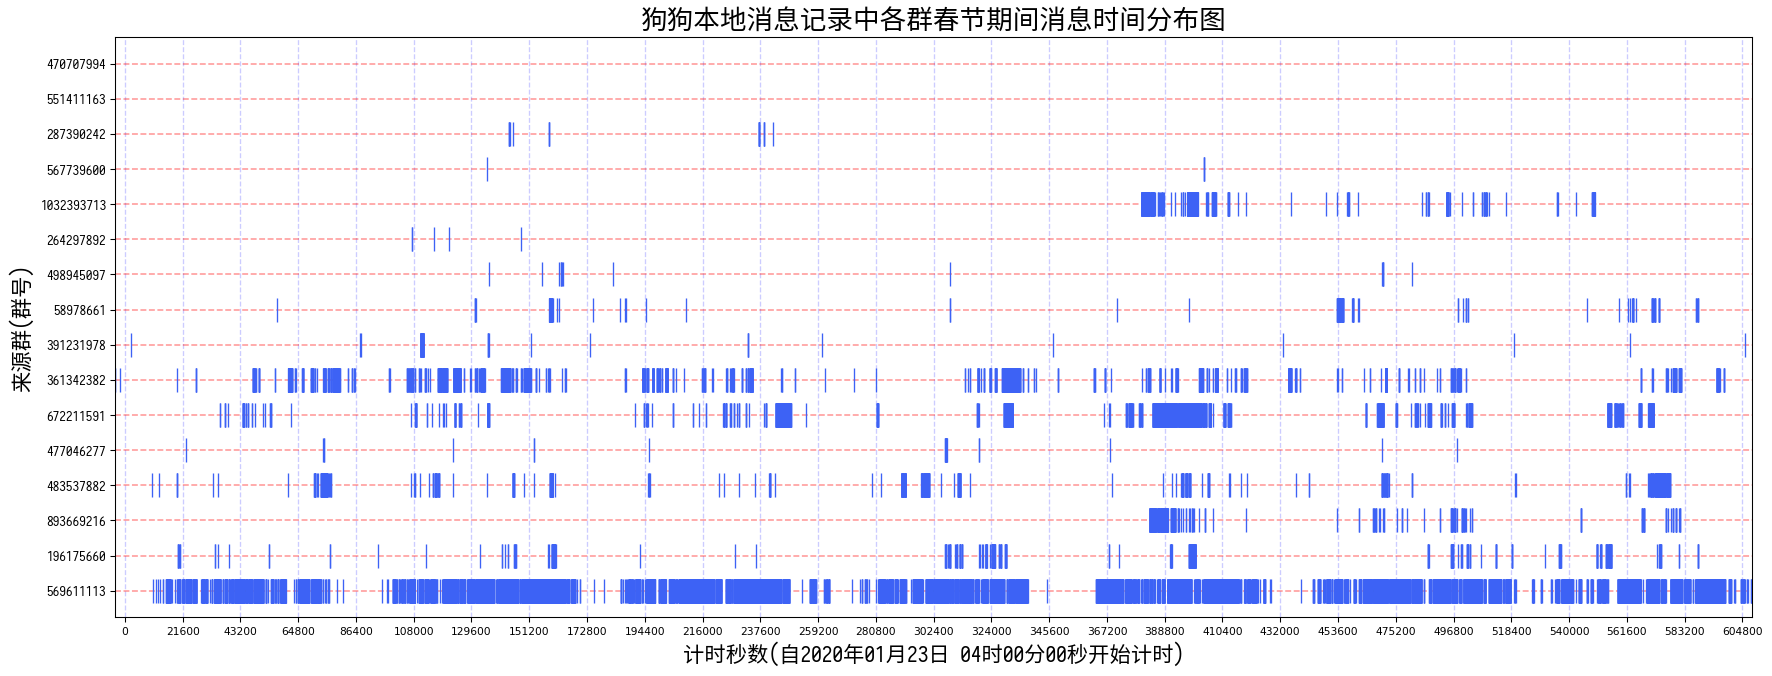

In [8]:
时间_单元格开始 = time.time()
狗狗喜欢的一个中文字体 = FontProperties(fname='/home/hooke/.local/share/fonts/sarasa-monoT-sc-medium.ttf').get_name()
plt.rcParams['font.monospace'] += [狗狗喜欢的一个中文字体]  
plt.rcParams['axes.unicode_minus'] = False
plt.figure(dpi=96, figsize = (22, 8))
plt.title(u"狗狗本地消息记录中各群春节期间消息时间分布图", fontproperties=狗狗喜欢的一个中文字体, size=20)
plt.ylabel(u"来源群(群号)", fontproperties=狗狗喜欢的一个中文字体, size = 16)
plt.xlabel(u"计时秒数(自%s开始计时)"%time.strftime("%Y年%m月%d日 %H时%M分%S秒", time.localtime(bias_time) ), fontproperties=狗狗喜欢的一个中文字体, size=16)
for 群号索引 in range(len(群号列表)):
    plt.plot([time for time, msg in 群消息记录[群号索引]], [群号索引 for i in range(len(群消息记录[群号索引]))], color='#3d62f5', marker='|', markersize=18, linewidth=0)
ax = plt.gca()
ax.yaxis.grid(True,color='r', linestyle ='--', linewidth=1.2, alpha=0.4)
ax.xaxis.grid(True,color='b', linestyle ='--', linewidth=1, alpha=0.2)
ax.xaxis.set_major_locator(MultipleLocator(60 * 60 * 6))
plt.yticks(size=8); plt.yticks(ticks = np.arange(len(群号列表)), labels=群号列表, fontproperties=狗狗喜欢的一个中文字体, size=10)
plt.xticks(size = 8); plt.xlim(-3600, 结束时间 - 起始时间 + 3600)
plt.savefig("./狗狗本地消息记录中各群消息时间分布图.png", dpi=144, bbox_inches='tight')
loggerP.info("处理本单元格耗时%0.3f毫秒. 绘制了%d个数据点" % ( (time.time() - 时间_单元格开始) * 1000 , len(CQ中的原始记录) ))

绘制并观察这个图, 方案验证表明[`开始的想法`](#大致思路)不可行, 很多时候时(时刻)空(来源)相邻的对话在内容上是没有关联的...这也就是说, 我花了5天做的上面这些方案验证都白费了...(其实应该实际观察一下, 不被定势思维干扰)不过吧, 我还是得出了一个结论 -- 嗯...我的群居然不是最冷的(多么痛的领悟)...

##### 尝试把上一节的语料库"喂"给Word2Vec  

In [9]:
# 这里需要提一下`gensim`库, 这个库本身是用来实现`主题模型`的, 即用于从文档中自动提取语义主题. 不过它非常全面且"多功能", 本文说的word2vec也集成在了gensim中.
%time from gensim.models import Word2Vec

CPU times: user 451 ms, sys: 1.57 s, total: 2.02 s
Wall time: 549 ms


*注, 在aarch64平台上有个坑 -- gensim依赖scipy, 可是[pypi-scipy](https://pypi.org/project/scipy/#files)上没有提供aarch64的包, 只能参考[Building from source on Linux](http://scipy.github.io/devdocs/building/linux.html#generic-instructions)自行编译安装. 当然, 用Windows(amd64)就没这些问题了...(别问我为啥非要用aarch64和Linux, 问就是穷...疯狂暗示...)*

这里先简单介绍一下`gensim.models.word2vec`的常规用法(还有高级用法就不赘述了), 参考[word2vec tutorial](https://rare-technologies.com/word2vec-tutorial/)总结如下:  
> Word2Vec有4个主要参数: `sentences`(list), `min_count`(int 0~100), `size`(int), `workers`(int):
>> `sentences`: 语料表. (二维list, 或者其他`句子[词...]...`形式的可迭代对象)  
>> `min_count`: 裁剪掉出现次数少于这个数量的词, 因为某些词可能是分词出错或者压根就是打字打错. 按语料库规模取0~100的整数值. (默认5)   
>> `size`: 模型的网络规模(也就是词向量的维数), 取值越大且语料库越大得到的效果越好. (默认100)  
>> `workers`: (依赖于Cython)并行进程数. (默认1.)

In [10]:
# 先把上一节的预处理结果读出来, 还需要一些处理才能"喂"
query_selectLog = "SELECT * FROM `ppcLog` ORDER by `lid` DESC;"
%time 预处理好的语料库 = pd.read_sql_query(query_selectLog, Conn_ppced)
loggerP.debug( "变量`预处理好的语料库`占用内存 → %0.3fKB" % (sys.getsizeof(预处理好的语料库) / 1000) ) 

CPU times: user 234 ms, sys: 37 ms, total: 271 ms
Wall time: 267 ms


+ [ DEBUG] | 2020-02-02 20:21:49,986 @    6121 +: 变量`预处理好的语料库`占用内存 → 32214.919KB


按一般经验来看, 一个句子一般至少要有三个语素, 否则很难确定含义, 但考虑到这里实际情况是随意的聊天对话, 句子成分少的很可能是一些不明确的回复. 所以这里经验按剔除`len(jiebaPSEG) <= 4`的记录.

In [11]:
# word2vec输入需要结构: `[[jieba分词结果0], ['来自', '616471607', '的', '私聊', '消息'], ..., ["xxx",..."yyy"]]`
# word2vec需要使用上下文语境来定义词汇的分布, 上下文即同一层级的句子.
时间_单元格开始 = time.time()

# 喂给wv的语料最好不要有太多重复, 这里做个省事的去重操作(没精力动脑筋了, 能用就行...) 
%time np.unique(预处理好的语料库.jiebaCUT[预处理好的语料库.cqCode == ""])

loggerP.log(11, "由于数据库里存的是`TEXT`形式. 比如`type(预处理好的语料库.iloc[6666][3])` → \n|\t{}\n|\t所以用`eval()`这个用于解释字符串的函数返回真正的list".format(type(预处理好的语料库.iloc[6666][3])))
%time 词表 = [ eval(预处理好的语料库.iloc[rowIndex][3]) for rowIndex in range(len(预处理好的语料库)) if len(eval(预处理好的语料库.iloc[rowIndex][4])) > 4 and ( 预处理好的语料库.iloc[rowIndex][3].find("[\u2333#][*un") < 0 ) ] # TODO 这非常粗暴, 需要优化
loggerP.info("处理本单元格耗时%0.3f秒. 裁剪并拼接得到%d个句子" % ( time.time() - 时间_单元格开始 , len(词表) ))

+ [  TIPS] | 2020-02-02 20:21:50,092 @    6227 +: 由于数据库里存的是`TEXT`形式. 比如`type(预处理好的语料库.iloc[6666][3])` → 
|	<class 'str'>
|	所以用`eval()`这个用于解释字符串的函数返回真正的list


CPU times: user 76.3 ms, sys: 0 ns, total: 76.3 ms
Wall time: 73.4 ms


+ [  INFO] | 2020-02-02 20:22:05,786 @   21920 +: 处理本单元格耗时15.769秒. 裁剪并拼接得到18464个句子


CPU times: user 15.6 s, sys: 26.5 ms, total: 15.6 s
Wall time: 15.7 s


In [12]:
loggerP.debug("`语料表`预览:\n::\n%s\n::" % (词表[217:233]))
loggerP.debug( "变量`词表`占用内存 → %0.3fKB" % (sys.getsizeof(词表) / 1000) ) 

+ [ DEBUG] | 2020-02-02 20:22:05,816 @   21950 +: `语料表`预览:
::
[['把', '音响', '的', '电源模块', '来', '给', 'ZVS', '供电', '看看'], ['要用', '2', 'KW', '的', '环牛'], ['全桥', '你', '给', '多少', '电压', '了'], ['我', '打算', '这样', '示波器', '用', '锂电', '供电', '这样', '随便', '玩'], ['50', 'V', '电压', '全桥', '最高', '57', 'V'], ['有钱人', '的', '时间', '真', '搞不懂', '也', '不', '知道', '做', '什么', '路上', '红毯', '铺', '了', '一千多米'], ['造谣', '是', '要', '进', '局子', '的'], ['凡是', '年收入', '4000', '元', '的', '都', '不是', '贫困户'], ['年', '收', '4000', '还', '不是', '贫困户', '我', '的', '天'], ['勉强', '养活', '也', '就', '一个', '人'], ['再', '大', '点', '看看', '听', '着', '舒服'], ['不', '知道', '吹', '压缩空气', '会不会', '制冷', '效果', '好'], ['这', '是', '资本主义', '说', '的话'], ['资本主义', '禁言', '要', '不要', '来', '一个'], ['我', '穷', '的', '只', '剩下', '圈子', '了'], ['买', '16', 'MM', '的', '铜管', '做', '初级', '也', '比', '搞', '一套', '冷却', '设备', '便宜']]
::
+ [ DEBUG] | 2020-02-02 20:22:05,824 @   21959 +: 变量`词表`占用内存 → 158.208KB


得到了这么一个二维列表就可以作为语料丢给`Word2Vec`去训练了. 当然, 在生成好语料表之后还应该人工检查一下(比如没去干净的URL、无实际意义的特殊成分比如艾特之类的)并根据实际情况调整修改预处理流程, 需要保证语料是通顺、有意义的.

In [13]:
%time 词向量模型 = Word2Vec(sentences=词表, min_count=50, size=512, workers=2)
词向量模型.save('tmpTest_CQ.wvMod') # "训练"得到的词向量模型可以保存到文件以便以后使用(比如追加训练之类的)

CPU times: user 3.46 s, sys: 44 ms, total: 3.5 s
Wall time: 2.05 s


In [14]:
# 大致瞅瞅都取出了哪些词
抽取出的词 = list(词向量模型.wv.vocab)
预览 = (抽取出的词[:50] + 抽取出的词[-50:]); 预览.insert(50, "|# ... #|")
print( 预览 )

['驱动', '电源', '和', '我', '就', '谁', '了', '像', '这种', '小', '功率', '都', '来自', '的', '有', '一个', '电容', '如果', '接', '在', '到', '电压', '时候', '直接', '还有', '供电', '不', '可', '这样', '干', '发现', '这', '咋', '人', '没', '要', '比', '板子', '好', '不好', '炸', '很', '的话', '看', '视频', '估计', 'ZVS', '已经', '烧', '更', '|# ... #|', '事', '哦', '低', '绕', 'DR', '它', '香', 'W', '死', '连', '一定', '干嘛', '挂', '自', '妈', '原来', '哪里', '保护', '二极管', '大佬', '新', '芯片', '见', '等', '有人', '别人', '懂', '之前', '特斯拉', '今天', '只要', 'K', '月', '灭弧', '但', '写', '号', '红包', '转', '启动', '.', '注册', '家里', '为', '口罩', '病毒', '软件', '螃蟹', '武汉', '官方']


In [15]:
# 可以大致试一下用训练好的模型查看和某个词最相关的词.
print(词向量模型.wv.most_similar(['CQ'],topn=4))
print(词向量模型.wv.most_similar(['ZVS']  ,topn=4))
print(词向量模型.wv.most_similar(['短路'] , topn=4))
print(词向量模型.wv.most_similar(['软件']   ,topn=4))
print(词向量模型.wv.most_similar(['推']   ,topn=4))

KeyError: "word 'CQ' not in vocabulary"

这么看着, 感觉好像不太对... 不过倒确实是能反映词之间的联系了(山猫是玩高压电的, 主打TC; 这个圈子里的"ZVS"常被用于指代一个用于驱动高压包或者做感应加热的电路; 短路了就懵逼; TC是一种用于演示电晕放电的观赏用闪电发生器, 那些弧状的电晕被圈子里的爱好者称为电弧; "推"在电子技术圈里常指"驱动"), 只是这个关联有点不准确, 就姑且认为是提供的训练语料不够充足吧...  
  
为了更直观地了解这个模型的效果, `数据可视化`是首选, 这里就用`PCA`(主成分分析, 能将现有的特征进行某些变换并选出最能表达该数据集的几个特征)模块来做2D可视化. 在python中可以方便地使用`sklearn`(全称Scikit-learn, 是机器学习中常用的第三方模块，对常用的机器学习方法进行了封装.)中的`sklearn.decomposition.PCA`

In [ ]:
# 用PCA做2d拟合并绘图
from sklearn.decomposition import PCA
词向量矩阵 = 词向量模型.wv.__getitem__(词向量模型.wv.vocab)
result = PCA(n_components=2).fit_transform(词向量矩阵) # 指定PCA模型为2维
words = list(词向量模型.wv.vocab)

In [ ]:
# 做个限幅, 有些太离散的点影响可视化效果就丢弃
待弃点索引 =[] #[ 索引 for 索引 in range(len(result)) if abs(result[索引, 0]) > 0.45 or result[索引, 1] > 0.006 or result[索引, 1] < -0.01 ]
result_plt = np.delete(result, 待弃点索引, axis=0)
words_plt = [ words[索引] for 索引 in range(len(words)) if 索引 not in 待弃点索引 ]

In [ ]:
%%timeit -r 1 -n 1
# 绘图, 以散点图的形式可视化
plt.figure(dpi=96, figsize = (18, 10)); plt.title(u"狗狗本地QQ群消息记录中词向量模型2D可视化分布图", fontproperties=狗狗喜欢的一个中文字体, size=20)
plt.scatter(result_plt[:, 0], result_plt[:, 1], s=4)
for i, word in enumerate(words_plt):
    plt.annotate(word, xy=(result_plt[i, 0], result_plt[i, 1]), fontproperties=狗狗喜欢的一个中文字体, size=10)
# 调整坐标以便观察

plt.savefig("./WordEmb_2D.png", dpi=144, bbox_inches='tight')

从这个图能大致看出, 越相关的词分布也越近. 这也就说明了